In [27]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

In [28]:
import sys; sys.path.append("../offline/")
import sparse, geom, utils

In [29]:
import spimage

In [30]:
import scipy.optimize as optimize
import scipy.stats as stats

In [31]:
run = 95

In [32]:
assembled = []
with sparse.SmallFrame("../data/r%04d_lowq.h5" %run, geometry="../geometry/b3_lowq.geom") as f:
    for i in range(f.nframes):
        assembled.append(f.assembled(i))
    mask = f.activepixels
assembled = np.array(assembled)

In [33]:
hitscore = assembled.sum(axis=(1,2))

In [34]:
#assembled_sorted = assembled[np.argsort(hitscore)[::-1]][:,:300,:300]
assembled_sorted = assembled[:,:300,:300]

In [35]:
cmask = mask[:300,:300]

## Experimental parameters

In [36]:
downsampling = 1
pixelsize = downsampling * 200e-6
distance = 1.62 #m
material = 'sucrose'
phenergy = 6000. #eV
wavelength = (1239.8418746 / phenergy) * 1e-9 # m
saturation_level = 10000
sh = assembled_sorted.shape[1:]
gain = 1 # ADUs per photn

## Centering parameters

In [37]:
centering_maxshift  = 40 / downsampling
centering_threshold = 0.5
centering_blur      = 4
centering_x0 = sh[1]/2.
centering_y0 = sh[0]/2.

## Sizing parameters

In [74]:
diameter_start  = 200 * 1e-9
intensity_start = 1. * 1e-3 / 1e-12 #[mJ/um2]
brute_evals = 200
rmax = 250 / downsampling
maskradius = 70 / downsampling

## Masks

In [75]:
def rmask(r, sh, cx, cy):
    ny, nx = sh
    xx,yy = np.meshgrid(np.arange(nx), np.arange(ny))
    return (xx-cx)**2 + (yy-cy)**2 > (r**2)

## Conversions

In [76]:
q_to_x = lambda q: np.tan(2.*np.arcsin(wavelength * q / 2.)) * distance / pixelsize
x_to_q = lambda x: (2*np.sin(np.arctan2(x*pixelsize, distance)/2.)) / wavelength
qr = spimage.x_to_qx(np.arange(0,sh[0]/2.), pixelsize/downsampling, distance)

## Cost function

In [77]:
def model(p,q):
    diameter, intensity = p
    A = spimage.sphere_model_convert_intensity_to_scaling(intensity, diameter, wavelength, pixelsize, 
                                                      distance, material=material)
    s = spimage.sphere_model_convert_diameter_to_size(diameter, wavelength, pixelsize, distance)
    I = spimage.I_sphere_diffraction(A,q,s)
    return I

In [78]:
def costfunc1(p, data, mask,q):
    return 1-stats.pearsonr(model([p,1e9],q)[mask],data[mask])[0]

In [79]:
def costfunc2(p, data, mask, diameter,q):
    return ((model([diameter,p],q)[mask] - data[mask])**2).sum()

In [80]:
def costfunc3(p, data, mask,q):
    return ((model(p,q)[mask] - data[mask])**2).sum()

In [81]:
def costfunc4(p, data, mask,diameter,q):
    return 1-stats.spearmanr(model([diameter,p],q)[mask],data[mask])[0]

## Pick a diffraction pattern

In [82]:
j = 10

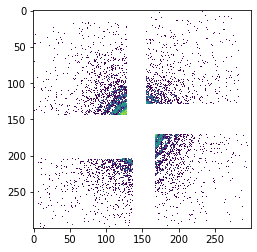

In [83]:
plt.imshow(assembled_sorted[j], norm=colors.LogNorm())

## Step. 1 Finding the center

In [84]:
x,y = spimage.find_center(assembled_sorted[j],cmask,method='blurred', 
                          x0=centering_x0, y0=centering_y0,dmax=centering_maxshift, 
                          threshold=centering_threshold, blur_radius=centering_blur)
print("Step 1: Found center position (%.2f, %2.f)" %(x,y))

Step 1: Found center position (-8.50, 12)


In [85]:
# Add spherical mask in the center (restricting the sizing to low q)
mask_sizing = cmask & ~rmask(maskradius, cmask.shape, cmask.shape[1]/2+x, cmask.shape[0]/2+y)

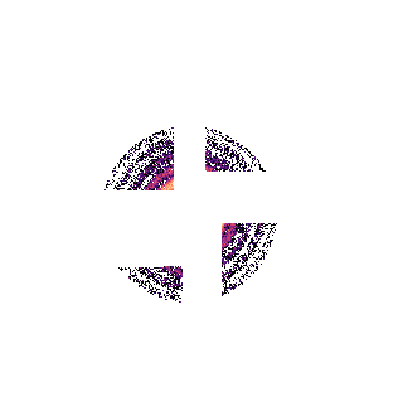

In [86]:
plt.figure(figsize=(5,5), dpi=100)
plt.axis('off')
plt.imshow(assembled_sorted[j]*cmask*mask_sizing, norm=colors.LogNorm(), cmap='magma')
plt.show()

## Step 2. Radial average

In [87]:
centers, radial = spimage.radialMeanImage(assembled_sorted[j], msk=cmask, cx=cmask.shape[1]/2+x, 
                                          cy=cmask.shape[0]/2+y, output_r=True)
data_r  = radial[:sh[0]//2]
data_qr = spimage.x_to_qx(centers, pixelsize, distance)[:sh[0]//2]
mask_qr = (data_qr > 30) #& (data_qr < 75)

## Step 3. Fitting size/intensity

In [88]:
output = optimize.brute(costfunc1, [(1e-9,401e-9)], args=(data_r, mask_qr, data_qr), Ns=400, full_output=True)
diameter = output[0]
pearson = output[1]

In [89]:
diameter, pearson

(array([  1.76714282e-07]), 0.054912161000103987)

In [90]:
res = optimize.minimize(costfunc2, [intensity_start], args=(data_r, mask_qr, diameter, data_qr), 
                        method="Powell", tol=None, options={'disp':False})
intensity = res['x']
fun = res['fun']
print(intensity, fun)

60996556.48780775 20.9832035506


In [91]:
res = optimize.minimize(costfunc3, [diameter, intensity], args=(data_r, mask_qr, data_qr), 
                        method="Powell", tol=None, options={'disp':False})
diameter = res['x'][0]
intensity = res['x'][1]
fun = res['fun']

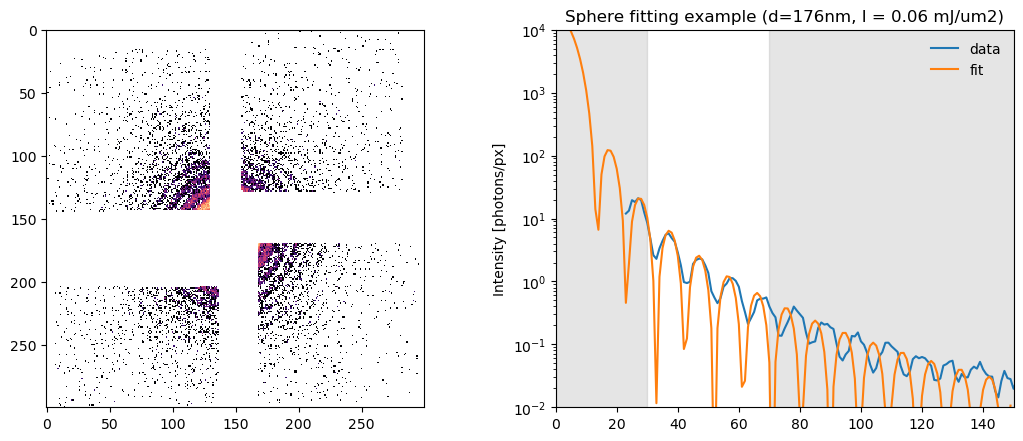

In [92]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5), dpi=100)
axes[0].imshow(assembled_sorted[j]*cmask, norm=colors.LogNorm(), cmap='magma')
axes[1].set_title("Sphere fitting example (d=%dnm, I = %.2f mJ/um2)" %(diameter*1e9, intensity / (1e-3 / 1e-12)))
axes[1].plot(data_qr, data_r, label="data")
axes[1].plot(qr, model([diameter,intensity],qr), label="fit")
axes[1].set_ylim(0.01, 1e4)
axes[1].set_xlim(0,sh[0]//2)
axes[1].axvspan(0,30, color='gray', alpha=0.2)
axes[1].axvspan(70,150, color='gray', alpha=0.2)
axes[1].semilogy()
axes[1].set_ylabel("Intensity [photons/px]")
axes[1].legend(frameon=0, loc=1)
plt.show()

In [93]:
def confidence(modelfunc, datay, datax, diameter, intensity, dmax=10e-9, imax=50, N=100, plevel=0.95):
    drange = np.linspace(diameter-dmax, diameter+dmax,N)
    irange = np.linspace(intensity*(1-imax/100.), intensity*(1+imax/100.),N)
    dd,ii = np.meshgrid(drange,irange)
    chisquared = np.zeros((N,N))
    for i in range(N):
        for j in range(N):
            fit = modelfunc([dd[j,i],ii[j,i]],datax)
            chisquared[j,i] = np.sum((fit-datay)**2)
    confmap = np.exp(-chisquared + chisquared.min())
    prob = (confmap/confmap.sum()).flatten()
    asort = np.argsort(prob)[::-1]
    confidence = prob[asort].cumsum() < plevel
    pmin = (prob[asort][confidence]*confmap.sum()).min()
    confmask = confmap > pmin 
    dlim = dd[confmask].min(), dd[confmask].max()
    ilim = ii[confmask].min(), ii[confmask].max()
    return confmap, dlim, ilim

In [94]:
C, dlim, ilim = confidence(model, data_r[mask_qr], data_qr[mask_qr], diameter, intensity)

In [95]:
derror = np.abs(diameter-dlim).max()/diameter
ierror = np.abs(intensity-ilim).max()/intensity

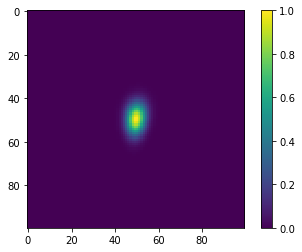

In [96]:
plt.imshow(C)
plt.colorbar()
plt.show()

In [97]:
print(derror, ierror, ierror, derror, derror/ierror)

[ 0.00858026] 0.116161616162 0.116161616162 [ 0.00858026] [ 0.07386485]
